In [88]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from scipy import stats
import numpy as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV, LinearRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn import metrics

### Importamos los datos

In [104]:
train = pd.read_csv(r"C:\Users\viole\Desktop\SCHOOL\AI\housePrices\train.csv")
test =  pd.read_csv(r"C:\Users\viole\Desktop\SCHOOL\AI\housePrices\test.csv")

In [63]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [105]:
train.shape

(1460, 81)

In [106]:
# Removemos la columna ID porque no es util para el analisis
train.drop('Id', axis = 1, inplace = True)
print('Sin ID el train set es de dimension: {}' .format(train.shape))
testID = test['Id']
test.drop('Id', axis = 1, inplace = True)
print('Sin ID el test set es de dimension: {}' .format(test.shape))

Sin ID el train set es de dimension: (1460, 80)
Sin ID el test set es de dimension: (1459, 79)


### Analizamos los datos faltantes

In [107]:
col_train = [col for col in train.columns if train[col].isnull().any()]
faltantes_train = ((train[col_train].isnull().sum()*100)/len(train)).round(3)
faltantes_train = faltantes_train.sort_values(ascending = False)

col_test = [col for col in test.columns if test[col].isnull().any()]
faltantes_test = ((test[col_test].isnull().sum()*100)/len(test)).round(3)
faltantes_test = faltantes_test.sort_values(ascending = False)

combined = pd.concat((faltantes_train, faltantes_test), keys = ['train', 'test'], axis = 1)
print(combined)

combined.reset_index(inplace = True)
combined= pd.melt(combined[:18], id_vars=['index'], value_vars=['train', 'test'],
                         var_name = 'set', value_name = 'porcentaje')

               train    test
PoolQC        99.521  99.794
MiscFeature   96.301  96.504
Alley         93.767  92.666
Fence         80.753  80.123
FireplaceQu   47.260  50.034
LotFrontage   17.740  15.559
GarageYrBlt    5.548   5.346
GarageType     5.548   5.209
GarageFinish   5.548   5.346
GarageQual     5.548   5.346
GarageCond     5.548   5.346
BsmtFinType2   2.603   2.879
BsmtExposure   2.603   3.016
BsmtFinType1   2.534   2.879
BsmtCond       2.534   3.084
BsmtQual       2.534   3.016
MasVnrArea     0.548   1.028
MasVnrType     0.548   1.097
Electrical     0.068     NaN
MSZoning         NaN   0.274
BsmtFullBath     NaN   0.137
BsmtHalfBath     NaN   0.137
Utilities        NaN   0.137
Functional       NaN   0.137
Exterior2nd      NaN   0.069
Exterior1st      NaN   0.069
SaleType         NaN   0.069
BsmtFinSF1       NaN   0.069
BsmtFinSF2       NaN   0.069
BsmtUnfSF        NaN   0.069
KitchenQual      NaN   0.069
GarageCars       NaN   0.069
GarageArea       NaN   0.069
TotalBsmtSF   

Text(0, 0.5, 'Porcentaje de datos faltantes')

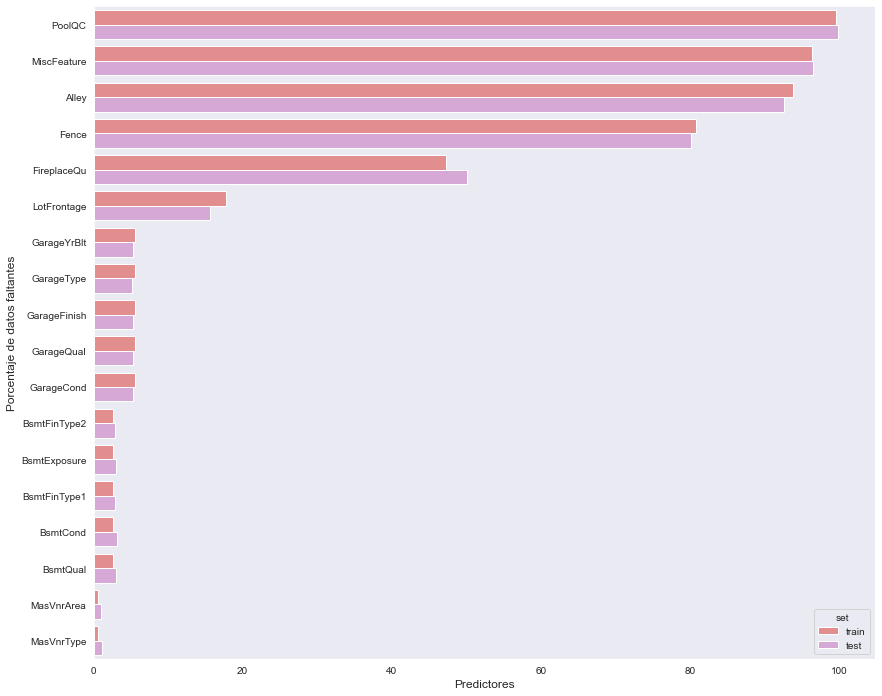

In [108]:
# Visualmente
sns.set_style("dark")
fig, ax = plt.subplots(figsize = (14, 12))
sns.barplot(x = combined['porcentaje'], y = combined['index'], hue = combined['set'], palette = ['lightcoral', 'plum'])
plt.xlabel('Predictores', fontsize = 12)
plt.ylabel('Porcentaje de datos faltantes', fontsize = 12)

En la descripción de los datos se indica que para Alley, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, PoolQC, Fence y MiscFeature la nomenclatura NA **no** indica un dato faltante sino la falta del feature en la propiedad (sin garage, sin piscina etc), así que sustituiremos NA por la categoría None. 
<p> La funcionalidad se asume típica, asi que sustituimos los faltantes por la categoría 'Typ'.

In [109]:
for col in ('Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','FireplaceQu', 
            'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'):
            train[col] = train[col].fillna('None')
            test[col] = test[col].fillna('None')
            

train['Functional'] = train['Functional'].fillna('Typ')
test['Functional'] = test['Functional'].fillna('Typ')

Si ocurrencias de NA son las mismas de MasVnrType y MasVnrArea  asumiremos que la propiedad no tiene esta estructura y por lo tanto el área de esta es 0.

In [110]:
for col in ('MasVnrType', 'MasVnrArea'):
    train['MasVnrType'] = train['MasVnrType'].fillna('None')
    train['MasVnrArea'] = train['MasVnrArea'].fillna(0)
    test['MasVnrType'] = test['MasVnrType'].fillna('None')
    test['MasVnrArea'] = test['MasVnrArea'].fillna(0)

Si no hay garage entonces su área es 0 al igual que el número de carros; y si no hay sótano los predictores BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath que indican áreas y número de baños también son 0.

In [111]:
for col in ('GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
        train[col] = train[col].fillna(0)
        test[col] = test[col].fillna(0)

LotFrontage indica la longitud de la calle frente a la propiedad, así que sustituimos los faltantes con la mediana de esta longitud por vecindario.

In [112]:
train['LotFrontage'] = train.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))
test['LotFrontage'] = test.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

Para los demás predictores categóricos sustituimos los faltantes con la categoría más común.

In [113]:
for col in ('Electrical', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'MSZoning', 'Utilities', 'SaleType'):
    train[col] = train[col].fillna(train[col].mode()[0])
    test[col] = test[col].fillna(test[col].mode()[0])

In [114]:
# Verificamos si quedan faltantes
col_train = [col for col in train.columns if train[col].isnull().any()]
col_test = [col for col in test.columns if test[col].isnull().any()]
print('En el trainset quedan {} '.format(len(col_train)),'columnas con datos faltantes.')
print('En el testset quedan {} '.format(len(col_test)),'columnas con datos faltantes.')

En el trainset quedan 0  columnas con datos faltantes.
En el testset quedan 0  columnas con datos faltantes.


In [115]:
# Borramos todo
del col_train
del col_test
del faltantes_train
del faltantes_test
del combined

### Correlación y visualización

SalePrice tiene sesgo:  1.8828757597682129


Text(0, 0.5, 'Frecuencia')

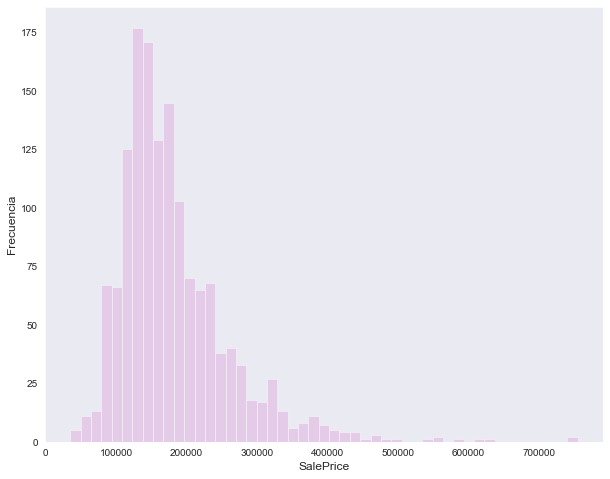

In [116]:
# Exploramos la respuesta
train.SalePrice.describe()
print ("SalePrice tiene sesgo: ", train.SalePrice.skew())

fig, ax = plt.subplots(figsize = (10, 8))
sns.distplot(train['SalePrice'], color = 'plum', kde = False)
plt.xlabel('SalePrice', fontsize = 12)
plt.ylabel('Frecuencia', fontsize = 12)

Vemos que la respuesta está sesgada hacia la derecha i.e. pocas personas pueden pagar propiedades muy costosas. Para corregir esto aplicaremos la transformación log.

El sesgo es ahora:  0.12133506220520406


Text(0, 0.5, 'Frecuencia')

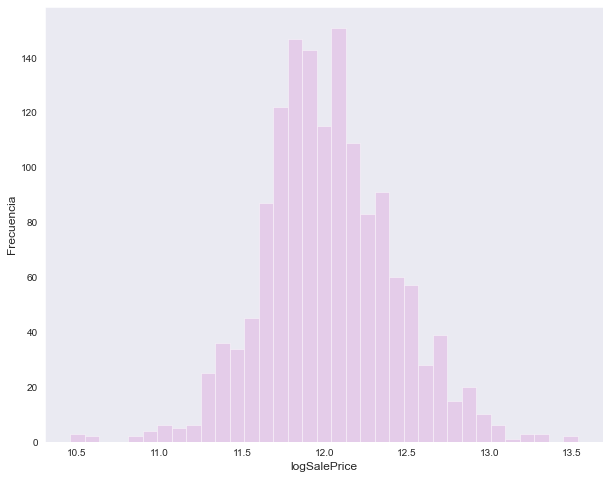

In [117]:
#log_y_train =  np.log(train.SalePrice)
train['logSalePrice'] = np.log(train['SalePrice']) 
print ('El sesgo es ahora: ', train.logSalePrice.skew())
train.drop('SalePrice', axis = 1, inplace = True)

fig, ax = plt.subplots(figsize = (10, 8))
sns.distplot(train['logSalePrice'], color = 'plum', kde = False)
plt.xlabel('logSalePrice', fontsize = 12)
plt.ylabel('Frecuencia', fontsize = 12)


#### Correlación entre los predictores

GarageCars   GarageArea      0.853317
TotalBsmtSF  1stFlrSF        0.829292
GrLivArea    TotRmsAbvGrd    0.827874
dtype: float64

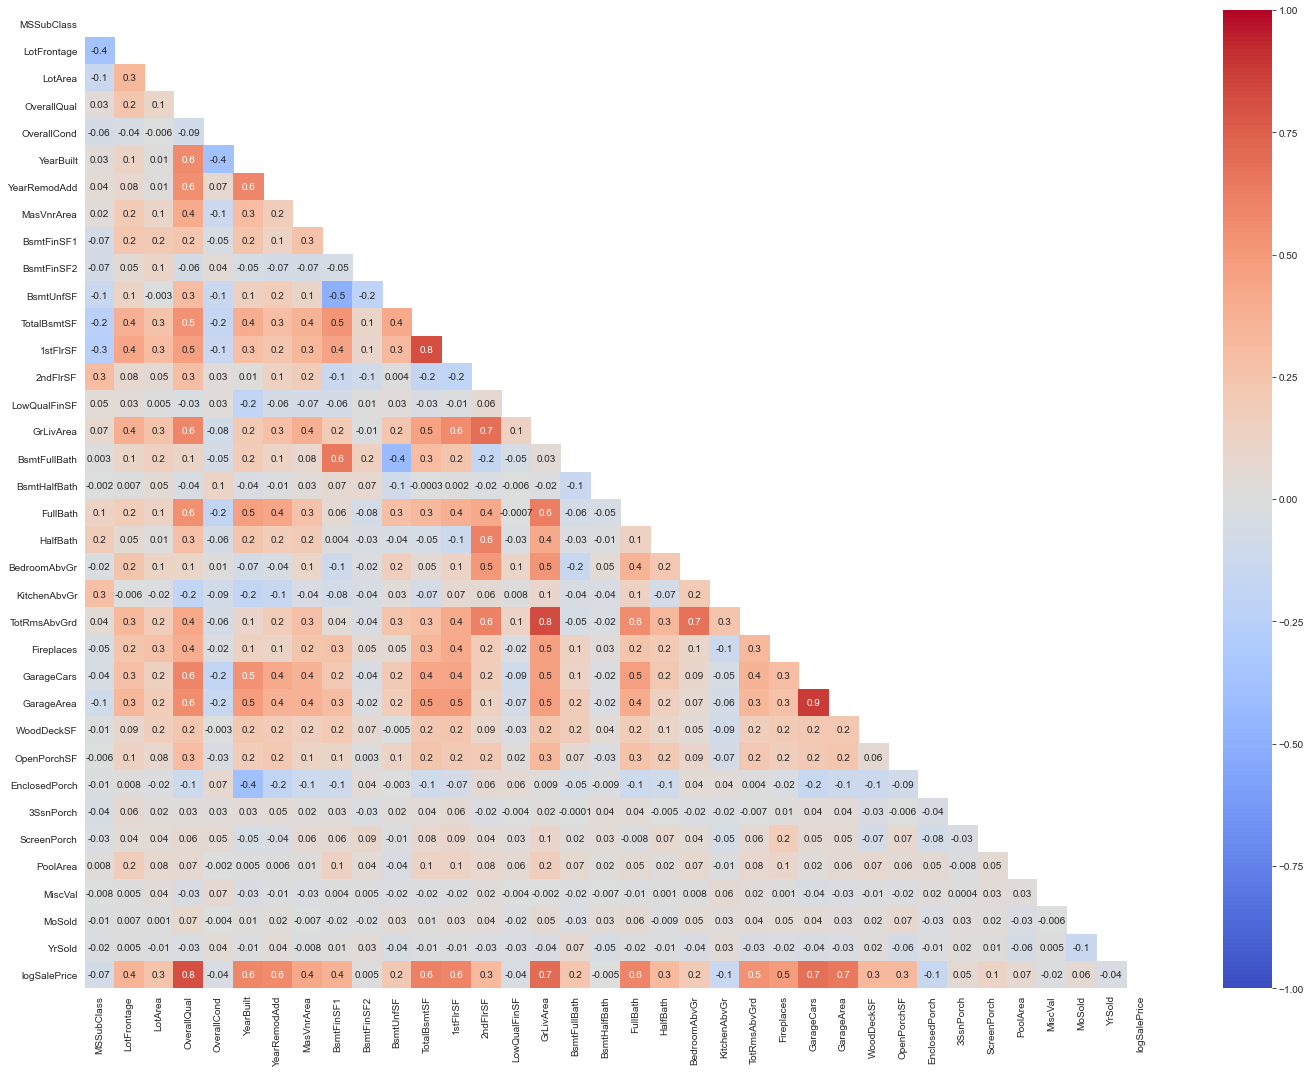

In [118]:
corr_matrix = train.corr(method = 'spearman')

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (24,18))
    sns.heatmap(train.corr(), vmin = -1, vmax = 1, cmap='coolwarm', annot=True, mask = np.triu(corr_matrix), fmt = '.1g')

# Predictores mas correlacionados entre si
corr_matrix = corr_matrix.abs()
most_corr = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))
most_corr.head(3)

In [119]:
corr_matrix = train.corr(method = 'spearman')['logSalePrice'][:-1] 
imp_features = corr_matrix[abs(corr_matrix) > 0.5].sort_values(ascending=False)
print("Hay {} predictores fuertemente correlacionados con logSalePrice:\n{}".format(len(imp_features), imp_features))

Hay 11 predictores fuertemente correlacionados con logSalePrice:
OverallQual     0.809829
GrLivArea       0.731310
GarageCars      0.690711
YearBuilt       0.652682
GarageArea      0.649379
FullBath        0.635957
TotalBsmtSF     0.602725
1stFlrSF        0.575408
YearRemodAdd    0.571159
TotRmsAbvGrd    0.532586
Fireplaces      0.519247
Name: logSalePrice, dtype: float64


<AxesSubplot:xlabel='GarageCars', ylabel='logSalePrice'>

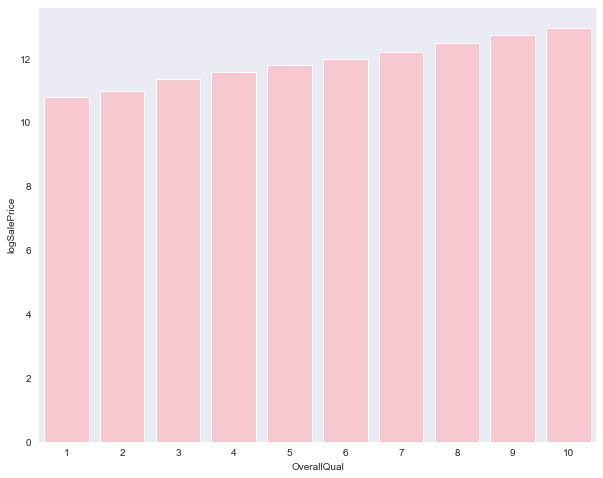

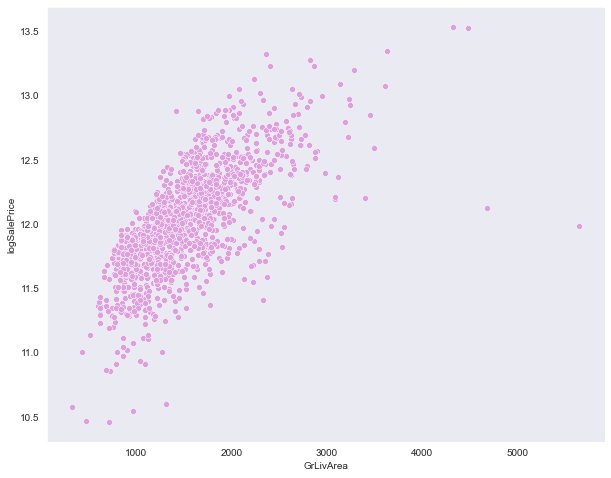

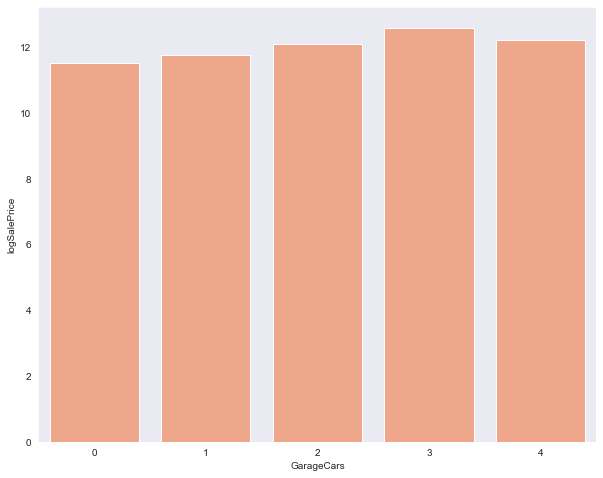

In [120]:
# Investigamos la relacion de la respuesta con algunos de estos predictores
train.OverallQual.unique()
quality_pivot = train.pivot_table(index='OverallQual', values='logSalePrice', aggfunc = np.median)

fig, ax = plt.subplots(figsize = (10,8))
sns.barplot(x = quality_pivot.index, y = quality_pivot.logSalePrice, color = 'pink')
fig, ax = plt.subplots(figsize = (10,8))
sns.scatterplot(x = train['GrLivArea'], y = train['logSalePrice'], color = 'plum')

cars_pivot = train.pivot_table(index='GarageCars', values='logSalePrice', aggfunc = np.median)
fig, ax = plt.subplots(figsize = (10,8))
sns.barplot(x = cars_pivot.index, y = cars_pivot.logSalePrice, color = 'lightsalmon')

### Codificación de variables dummys

In [121]:
from sklearn.preprocessing import LabelEncoder

# Primero aislamos las ordinales
ordinals = ('Alley', 'BsmtCond', 'BsmtFinType2', 'BsmtFinType1', 'BsmtExposure', 'BsmtQual', 
            'CentralAir','ExterCond', 'ExterQual', 'Fence', 'FireplaceQu', 'Functional', 'GarageQual', 
            'GarageCond', 'HeatingQC', 'PoolQC', 'KitchenQual',  
          'GarageFinish', 'LandSlope', 'LandContour',
        'LotShape', 'PavedDrive', 'Street',  'MSSubClass', 'OverallCond')

for col in ordinals:
    label = LabelEncoder() 
    label.fit(list(train[col].values)) 
    train[col] = label.transform(list(train[col].values))
    label = LabelEncoder()
    label.fit(list(test[col].values)) 
    test[col] = label.transform(list(test[col].values))


In [122]:
dummy_cols = train.select_dtypes(include = 'object').columns #son las mismas en train & test

train_y = train.logSalePrice.values
train.drop('logSalePrice', axis = 1, inplace = True)

train_objs_num = len(train)
dataset = pd.concat(objs=[train, test], axis=0)
dataset = pd.get_dummies(dataset, columns = dummy_cols, drop_first = True)
train = dataset[:train_objs_num]
test = dataset[train_objs_num:]


(1460, 301)
(1459, 301)
    MSSubClass  LotFrontage  LotArea  Street  Alley  LotShape  LandContour  \
0            5         65.0     8450       1      1         3            3   
1            0         80.0     9600       1      1         3            3   
2            5         68.0    11250       1      1         0            3   
3            6         60.0     9550       1      1         0            3   
4            5         84.0    14260       1      1         0            3   
5            4         85.0    14115       1      1         0            3   
6            0         75.0    10084       1      1         3            3   
7            5         80.0    10382       1      1         0            3   
8            4         51.0     6120       1      1         3            3   
9           14         50.0     7420       1      1         3            3   
10           0         70.0    11200       1      1         3            3   
11           5         85.0    11924    

# Modelos

In [123]:
# Separamos en training y test set
X_train, X_test, y_train, y_test = train_test_split(train, train_y, random_state = 42, test_size = 0.33)


In [124]:
# Aqui haremos cross validation para encontrar los hyperparámetros óptimos

ridgecv = RidgeCV(alphas = np.linspace(0.01,10,30), normalize = True)
ridgecv.fit(X_train, y_train)
print('Alpha de Ridge : {}' .format(ridgecv.alpha_))

lassocv = LassoCV(alphas = None, cv = 5, normalize = True)
lassocv.fit(X_train, y_train)
print('Alpha de Lasso : {}' .format(lassocv.alpha_))

elasticnetcv = ElasticNetCV(cv = 5)
elasticnetcv.fit(X_train, y_train)
print('Alpha de EN: {}' .format(elasticnetcv.alpha_))

Alpha de Ridge : 0.6989655172413793
Alpha de Lasso : 0.0005054521131845069
Alpha de EN: 2.3283061684653106


In [125]:
# Instanciamos los modelos con los parámetros encontrados arriba

lr = LinearRegression()
ridge_reg = Ridge(normalize = True)
ridge_reg.set_params(alpha = ridgecv.alpha_)
lasso_reg = Lasso(normalize = True)
lasso_reg.set_params(alpha = lassocv.alpha_)
elasticNet_reg = ElasticNet()
elasticNet_reg.set_params(alpha = elasticnetcv.alpha_, l1_ratio = elasticnetcv.l1_ratio_)

ElasticNet(alpha=2.3283061684653106)

In [126]:
# Ahora evaluamos y comparamos
mnames = ['Linear Reg', 'Ridge', 'Lasso', 'Elastic Net']
models = [lr, ridge_reg, lasso_reg, elasticNet_reg]

R_squared_test = []
RMSE_test = []
R_squared_train = []
RMSE_train = []


# Funcion que evalua R^2 y RMSE en el train set y training set
def performance(model, X_train, y_train):
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, prediction)
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test, prediction))
    plt.figure(figsize = (10,6))
    sns.distplot(y_test, color = 'darkturquoise', kde = False)
    sns.distplot(prediction, color = 'goldenrod', kde = False)
    plt.legend(labels = ['Actual', 'Predicted'])
    prediction = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, prediction)
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, prediction))
    return r2_test, r2_train, rmse_test, rmse_train


,R2 test,RMSE test,R2 train,RMSE train
Linear Reg,0.799397,0.184903,0.947127,0.090231
Ridge,0.874978,0.145971,0.903732,0.121753
Lasso,0.869980,0.148860,0.866234,0.143520
Elastic Net,0.802313,0.183554,0.737832,0.200922


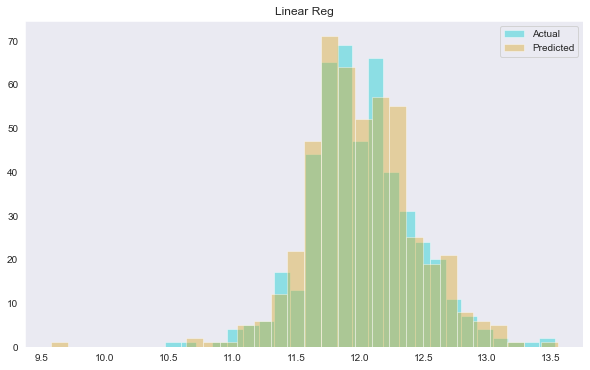

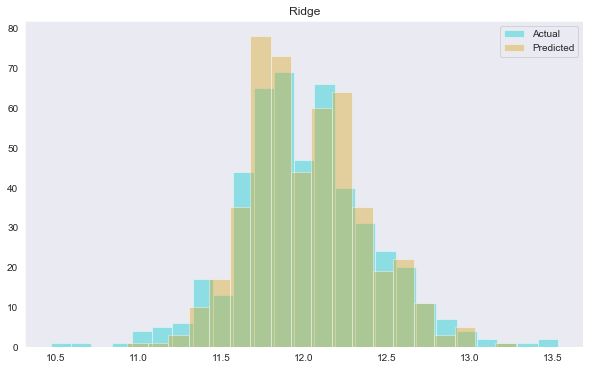

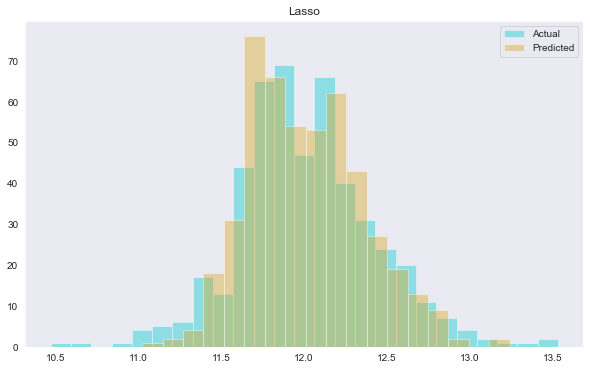

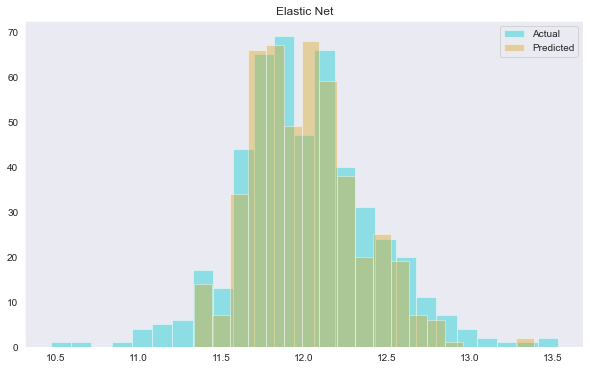

In [127]:
i = 0
for model in models:
    r2_test, r2_train, rmse_test, rmse_train = performance(model, X_train, y_train)
    R_squared_test.append(r2_test)
    RMSE_test.append(rmse_test)
    R_squared_train.append(r2_train)
    RMSE_train.append(rmse_train)
    plt.title(mnames[i])
    i=i+1
    
comparison = pd.DataFrame({'R2 test':R_squared_test,'RMSE test':RMSE_test, 
                           'R2 train':R_squared_train,'RMSE train':RMSE_train}, index = mnames) 
comparison

In [128]:
# Elegimos la regresión Ridge como mejor modelo respecto a R^2 y RMSE y guardamos las predicciones
submission = pd.DataFrame()
submission['Id'] = testID
predictions = ridge_reg.predict(test)
submission['SalePrice'] = np.exp(predictions)
submission.head()
submission.to_csv('submission1.csv', index=False)